In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import cv2
import re
import numpy as np
from tensorflow.keras.backend import int_shape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, UpSampling2D, UpSampling3D, Add, BatchNormalization, Input, Activation, Lambda, Concatenate
from tensorflow import keras

In [2]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

In [3]:
threshold = 0.5
metric = keras.metrics.MeanIoU(num_classes=2)
def mean_iou_threshold(y_true, y_pred):
    y_pred = y_pred.numpy()
    y_pred[y_pred > threshold]= 1
    y_pred[y_pred <= threshold] = 0
    metric.reset_states()
    metric.update_state(y_true, y_pred)
    return metric.result().numpy()

2021-10-15 08:06:52.624791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-15 08:06:52.684900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-15 08:06:52.685366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-15 08:06:52.686737: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
def bgr_to_rgb(img):
    b,g,r = cv2.split(img)
    return cv2.merge([r,g,b])

def get_label(file: str, labels: dict):
    match = re.search('[a-z]+', file).group(0)
    return labels[match]

def load_all_imgs(path, img_size, mode):
    imgs = []
    files = os.listdir(path)
    files.sort()
    print(f'\n{path} found {len(files)} img to load')
    for index, file in enumerate(files):
        img_path = os.path.join(path, file)
        img = cv2.imread(img_path, mode)
        
        if mode == 0:
            img = np.expand_dims(img, 2)
        
        if mode == 1:
            img = bgr_to_rgb(img)
        img = cv2.resize(img, img_size)
        img = img / 255.
        imgs.append(img)
        if index % 100 == 0:
            print(f'\n[{index}]:', end='')
        else:
            print("|", end='')
    return np.array(imgs)

In [5]:
def res_unet(filter_root, depth, n_class=2, input_size=(256, 256, 1), activation='relu', batch_norm=True, final_activation='softmax'):
    """
    Build UNet model with ResBlock.
    Args:
        filter_root (int): Number of filters to start with in first convolution.
        depth (int): How deep to go in UNet i.e. how many down and up sampling you want to do in the model. 
                    Filter root and image size should be multiple of 2^depth.
        n_class (int, optional): How many classes in the output layer. Defaults to 2.
        input_size (tuple, optional): Input image size. Defaults to (256, 256, 1).
        activation (str, optional): activation to use in each convolution. Defaults to 'relu'.
        batch_norm (bool, optional): To use Batch normaliztion or not. Defaults to True.
        final_activation (str, optional): activation for output layer. Defaults to 'softmax'.
    Returns:
        obj: keras model object
    """
    inputs = Input(input_size)
    x = inputs
    # Dictionary for long connections
    long_connection_store = {}

    if len(input_size) == 3:
        Conv = Conv2D
        MaxPooling = MaxPooling2D
        UpSampling = UpSampling2D
    elif len(input_size) == 4:
        Conv = Conv3D
        MaxPooling = MaxPooling3D
        UpSampling = UpSampling3D

    # Down sampling
    for i in range(depth):
        out_channel = 2**i * filter_root

        # Residual/Skip connection
        res = Conv(out_channel, kernel_size=1, padding='same', use_bias=False, name="Identity{}_1".format(i))(x)

        # First Conv Block with Conv, BN and activation
        conv1 = Conv(out_channel, kernel_size=3, padding='same', name="Conv{}_1".format(i))(x)
        if batch_norm:
            conv1 = BatchNormalization(name="BN{}_1".format(i))(conv1)
        act1 = Activation(activation, name="Act{}_1".format(i))(conv1)

        # Second Conv block with Conv and BN only
        conv2 = Conv(out_channel, kernel_size=3, padding='same', name="Conv{}_2".format(i))(act1)
        if batch_norm:
            conv2 = BatchNormalization(name="BN{}_2".format(i))(conv2)

        resconnection = Add(name="Add{}_1".format(i))([res, conv2])

        act2 = Activation(activation, name="Act{}_2".format(i))(resconnection)

        # Max pooling
        if i < depth - 1:
            long_connection_store[str(i)] = act2
            x = MaxPooling(padding='same', name="MaxPooling{}_1".format(i))(act2)
        else:
            x = act2

    # Upsampling
    for i in range(depth - 2, -1, -1):
        out_channel = 2**(i) * filter_root

        # long connection from down sampling path.
        long_connection = long_connection_store[str(i)]

        up1 = UpSampling(name="UpSampling{}_1".format(i))(x)
        up_conv1 = Conv(out_channel, 2, activation='relu', padding='same', name="upConv{}_1".format(i))(up1)

        #  Concatenate.
        up_conc = Concatenate(axis=-1, name="upConcatenate{}_1".format(i))([up_conv1, long_connection])

        #  Convolutions
        up_conv2 = Conv(out_channel, 3, padding='same', name="upConv{}_2".format(i))(up_conc)
        if batch_norm:
            up_conv2 = BatchNormalization(name="upBN{}_1".format(i))(up_conv2)
        up_act1 = Activation(activation, name="upAct{}_1".format(i))(up_conv2)

        up_conv2 = Conv(out_channel, 3, padding='same', name="upConv{}_3".format(i))(up_act1)
        if batch_norm:
            up_conv2 = BatchNormalization(name="upBN{}_2".format(i))(up_conv2)

        # Residual/Skip connection
        res = Conv(out_channel, kernel_size=1, padding='same', use_bias=False, name="upIdentity{}_1".format(i))(up_conc)

        resconnection = Add(name="upAdd{}_1".format(i))([res, up_conv2])

        x = Activation(activation, name="upAct{}_2".format(i))(resconnection)

    # Final convolution
    output = Conv(n_class, 1, padding='same', activation=final_activation, name='output')(x)

    return Model(inputs, outputs=output, name='Res-UNet')

In [6]:
model = res_unet(32, 5, input_size=(128, 128, 3), n_class=1,final_activation='sigmoid')
model.compile(run_eagerly=True,optimizer="adam", loss="binary_crossentropy", metrics=mean_iou_threshold)

In [7]:
model.summary()

Model: "Res-UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv0_1 (Conv2D)                (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
BN0_1 (BatchNormalization)      (None, 128, 128, 32) 128         Conv0_1[0][0]                    
__________________________________________________________________________________________________
Act0_1 (Activation)             (None, 128, 128, 32) 0           BN0_1[0][0]                      
___________________________________________________________________________________________

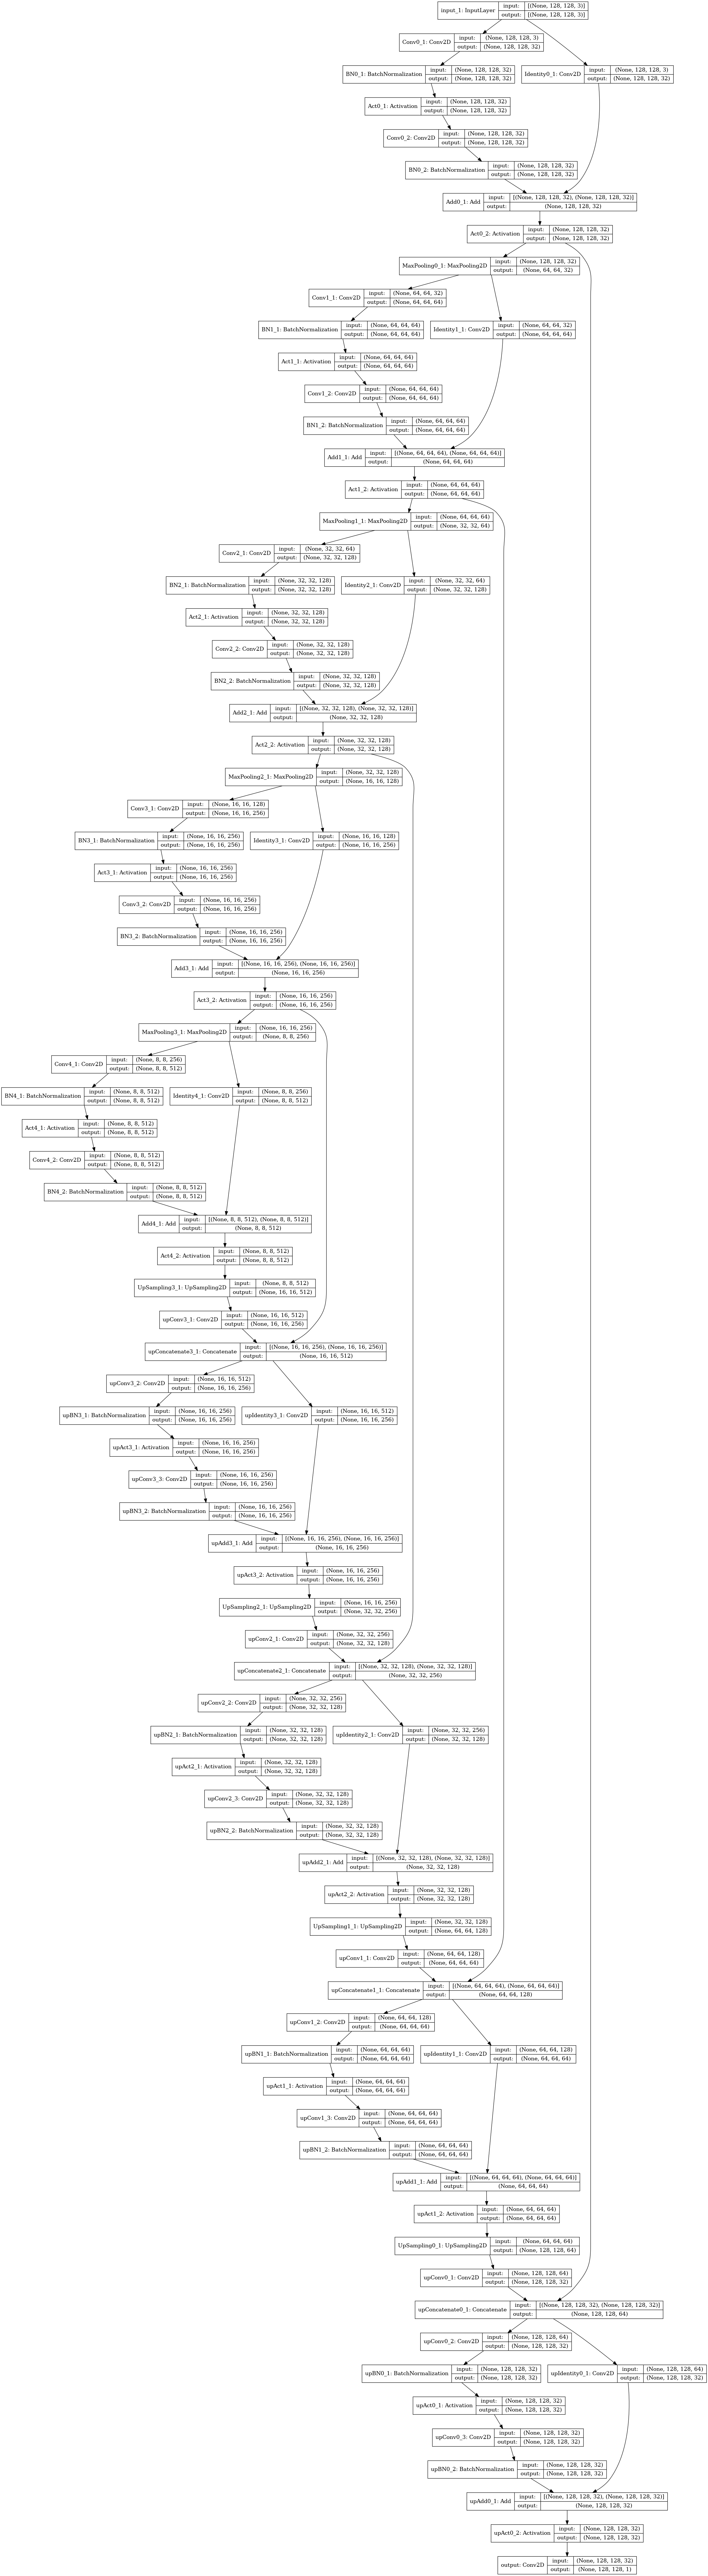

In [8]:
import tensorflow as tf

tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True)

In [11]:
img_size = (128, 128)
input_dir = "../dataset/segmentation/all_seg/"
target_dir = "../dataset/segmentation/annotation/all/"
num_classes = 1
batch_size = 10
epochs = 200

In [12]:
# Load images
trainImgs = load_all_imgs(input_dir,img_size, 1)
validImgs = load_all_imgs(target_dir,img_size, 0)


../dataset/segmentation/all_seg/ found 120 img to load

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||
../dataset/segmentation/annotation/all/ found 120 img to load

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||

In [13]:
img_to_test = int(len(trainImgs) * 0.8)
x_train = trainImgs[0:img_to_test]
y_train = validImgs[0:img_to_test]
x_val = trainImgs[img_to_test:]
y_val = validImgs[img_to_test:]
validation_data = (x_val, y_val)
print("ImgToTest:",img_to_test)
print("Validation_data_size:", len(validation_data[0]))

ImgToTest: 96
Validation_data_size: 24


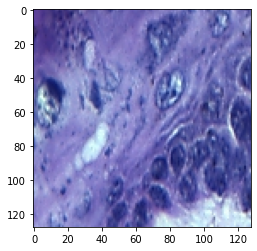

In [14]:
plt.imshow(trainImgs[0])

In [15]:
pred = model.predict(x_train)

2021-10-15 08:07:48.527515: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-15 08:07:49.712099: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


In [16]:
pred.shape

(96, 128, 128, 1)

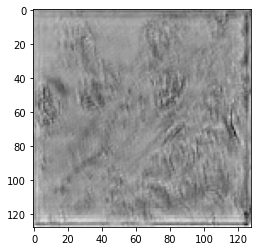

In [17]:
plt.imshow(pred[0], cmap='gray')

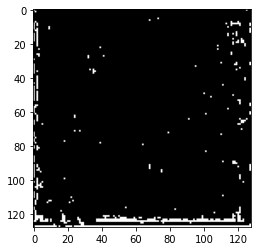

In [18]:
from matplotlib.colors import NoNorm
predict_img = pred[80]
predict_img[predict_img > 0.5] = 1
predict_img[predict_img <= 0.5] = 0

plt.imshow(predict_img, cmap='gray', norm=NoNorm())

In [19]:
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
model.fit(x_train, y_train, batch_size=batch_size,epochs=epochs, validation_data=validation_data, callbacks=callbacks)

Epoch 1/200
10/10 [==============================] - 9s 616ms/step - loss: 0.5183 - mean_iou_threshold: 0.5624 - val_loss: 0.5833 - val_mean_iou_threshold: 0.3842


/home/neto/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/200
10/10 [==============================] - 3s 252ms/step - loss: 0.4081 - mean_iou_threshold: 0.6485 - val_loss: 0.5902 - val_mean_iou_threshold: 0.3842
Epoch 3/200
10/10 [==============================] - 3s 252ms/step - loss: 0.3819 - mean_iou_threshold: 0.6703 - val_loss: 0.5923 - val_mean_iou_threshold: 0.3871
Epoch 4/200
10/10 [==============================] - 3s 252ms/step - loss: 0.3550 - mean_iou_threshold: 0.6959 - val_loss: 1.2642 - val_mean_iou_threshold: 0.3851
Epoch 5/200
10/10 [==============================] - 3s 256ms/step - loss: 0.3557 - mean_iou_threshold: 0.6965 - val_loss: 1.0924 - val_mean_iou_threshold: 0.3842
Epoch 6/200
10/10 [==============================] - 3s 256ms/step - loss: 0.3420 - mean_iou_threshold: 0.7045 - val_loss: 0.9403 - val_mean_iou_threshold: 0.3842
Epoch 7/200
10/10 [==============================] - 2s 251ms/step - loss: 0.3370 - mean_iou_threshold: 0.7083 - val_loss: 0.6572 - val_mean_iou_threshold: 0.3843
Epoch 8/200
10/10 [===

10/10 [==============================] - 3s 263ms/step - loss: 0.0713 - mean_iou_threshold: 0.9025 - val_loss: 0.5206 - val_mean_iou_threshold: 0.6806
Epoch 53/200
10/10 [==============================] - 3s 266ms/step - loss: 0.0697 - mean_iou_threshold: 0.8997 - val_loss: 0.5306 - val_mean_iou_threshold: 0.6777
Epoch 54/200
10/10 [==============================] - 3s 261ms/step - loss: 0.0633 - mean_iou_threshold: 0.9052 - val_loss: 0.5233 - val_mean_iou_threshold: 0.6821
Epoch 55/200
10/10 [==============================] - 3s 265ms/step - loss: 0.0632 - mean_iou_threshold: 0.8961 - val_loss: 0.5587 - val_mean_iou_threshold: 0.6872
Epoch 56/200
10/10 [==============================] - 3s 261ms/step - loss: 0.0628 - mean_iou_threshold: 0.9089 - val_loss: 0.5496 - val_mean_iou_threshold: 0.6843
Epoch 57/200
10/10 [==============================] - 3s 263ms/step - loss: 0.0622 - mean_iou_threshold: 0.9023 - val_loss: 0.5429 - val_mean_iou_threshold: 0.6827
Epoch 58/200
10/10 [=========

10/10 [==============================] - 3s 263ms/step - loss: 0.0399 - mean_iou_threshold: 0.9148 - val_loss: 0.7032 - val_mean_iou_threshold: 0.6585
Epoch 103/200
10/10 [==============================] - 3s 265ms/step - loss: 0.0391 - mean_iou_threshold: 0.9150 - val_loss: 0.6971 - val_mean_iou_threshold: 0.6719
Epoch 104/200
10/10 [==============================] - 3s 253ms/step - loss: 0.0393 - mean_iou_threshold: 0.9155 - val_loss: 0.7218 - val_mean_iou_threshold: 0.6606
Epoch 105/200
10/10 [==============================] - 3s 263ms/step - loss: 0.0390 - mean_iou_threshold: 0.9150 - val_loss: 0.7190 - val_mean_iou_threshold: 0.6666
Epoch 106/200
10/10 [==============================] - 3s 254ms/step - loss: 0.0384 - mean_iou_threshold: 0.9158 - val_loss: 0.7171 - val_mean_iou_threshold: 0.6621
Epoch 107/200
10/10 [==============================] - 3s 272ms/step - loss: 0.0386 - mean_iou_threshold: 0.9155 - val_loss: 0.7243 - val_mean_iou_threshold: 0.6632
Epoch 108/200
10/10 [===

Epoch 152/200
10/10 [==============================] - 3s 253ms/step - loss: 0.0355 - mean_iou_threshold: 0.9175 - val_loss: 0.7678 - val_mean_iou_threshold: 0.6688
Epoch 153/200
10/10 [==============================] - 3s 253ms/step - loss: 0.0360 - mean_iou_threshold: 0.9162 - val_loss: 0.7511 - val_mean_iou_threshold: 0.6693
Epoch 154/200
10/10 [==============================] - 3s 256ms/step - loss: 0.0357 - mean_iou_threshold: 0.9153 - val_loss: 0.7436 - val_mean_iou_threshold: 0.6733
Epoch 155/200
10/10 [==============================] - 3s 252ms/step - loss: 0.0353 - mean_iou_threshold: 0.9121 - val_loss: 0.7635 - val_mean_iou_threshold: 0.6673
Epoch 156/200
10/10 [==============================] - 3s 252ms/step - loss: 0.0355 - mean_iou_threshold: 0.9166 - val_loss: 0.7826 - val_mean_iou_threshold: 0.6748
Epoch 157/200
10/10 [==============================] - 3s 252ms/step - loss: 0.0359 - mean_iou_threshold: 0.9137 - val_loss: 0.7751 - val_mean_iou_threshold: 0.6700
Epoch 158/

In [20]:
val_preds = model.predict(np.array([trainImgs[0]]))

In [21]:
val_preds.shape

(1, 128, 128, 1)

In [22]:
def display_mask(img):
    """Quick utility to display a model's prediction."""
    predict_img = img
    predict_img[predict_img > threshold] = 1
    predict_img[predict_img <= threshold] = 0

    predict_img_original_size = cv2.resize(
        predict_img,
        (128, 128),
        interpolation=cv2.INTER_NEAREST
    )
    predict_img_original_size = predict_img_original_size * 255.0
    plt.imshow(predict_img_original_size, cmap=plt.cm.binary)

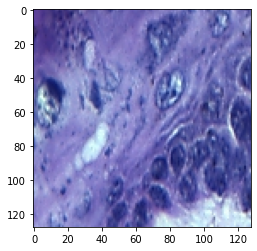

In [23]:
# Display input image
plt.imshow(trainImgs[0])

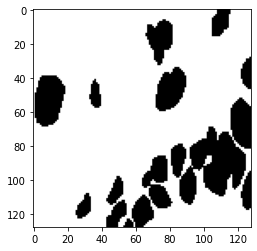

In [24]:
# Display ground-truth target mask
display_mask(validImgs[0])

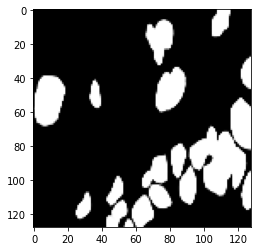

In [25]:
plt.imshow(val_preds[0], cmap='gray')

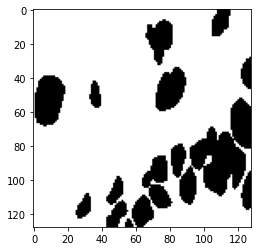

In [26]:
display_mask(val_preds[0])

In [27]:
def plot_result(img_pred, original, valid):
    plt.figure(figsize=(10, 10))
    n = 1
    for index, img in enumerate(img_pred):
        for i in range(3):
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.subplot(img_pred.shape[0] , 3, n)
            if i == 0:
                original_img = cv2.resize(original[index], img_size)
                plt.imshow(original_img)
                plt.xlabel("Original ")
            if i == 1:
                result_img = cv2.resize(img, img_size)
                plt.imshow(result_img, cmap=plt.cm.binary)
                plt.xlabel("Result", )
            if i == 2:
                valid_img = cv2.resize(valid[index], img_size)
                plt.imshow(valid_img, cmap=plt.cm.binary)
                plt.xlabel("Expected")
            n += 1


../dataset/segmentation/healthy/ found 30 img to load

[0]:|||||||||||||||||||||||||||||
../dataset/segmentation/annotation/healthy/ found 30 img to load

[0]:|||||||||||||||||||||||||||||

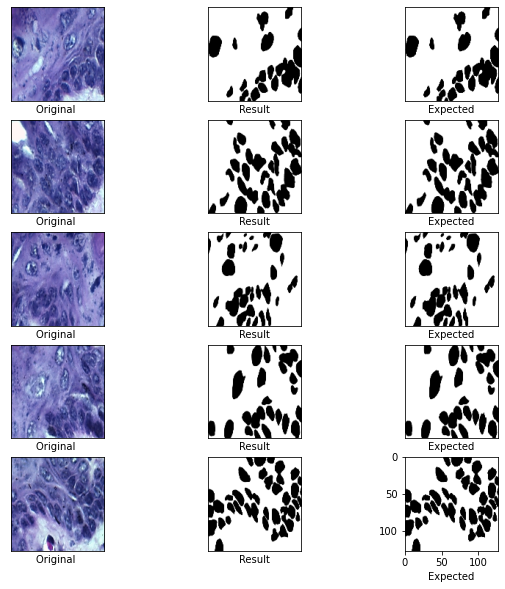

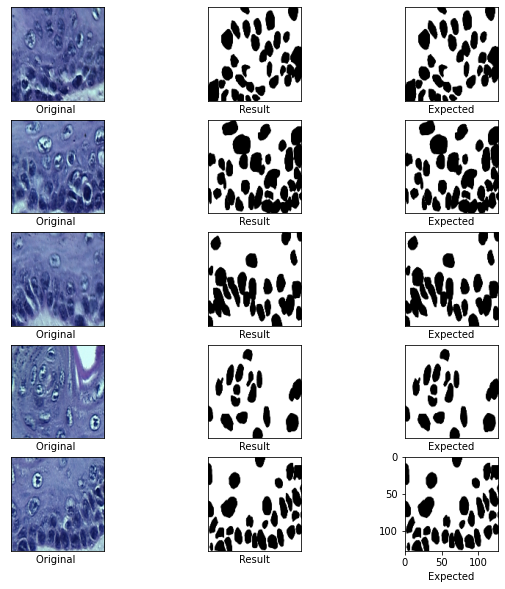

In [28]:
path_healthy_img = '../dataset/segmentation/healthy/'
path_healthy_val = '../dataset/segmentation/annotation/healthy/'

healthy_img = load_all_imgs(path_healthy_img, img_size, 1)
healthy_val = load_all_imgs(path_healthy_val, img_size, 0)
healthy_pred = model.predict(healthy_img)
# ----- Primeiras 5 Imagens -----
plot_result(healthy_pred[:5], healthy_img[:5], healthy_val[:5])
# ----- Ultimas 5 Imagens -----
plot_result(healthy_pred[-5:], healthy_img[-5:], healthy_val[-5:])


../dataset/segmentation/mild/ found 30 img to load

[0]:|||||||||||||||||||||||||||||
../dataset/segmentation/annotation/mild/ found 30 img to load

[0]:|||||||||||||||||||||||||||||

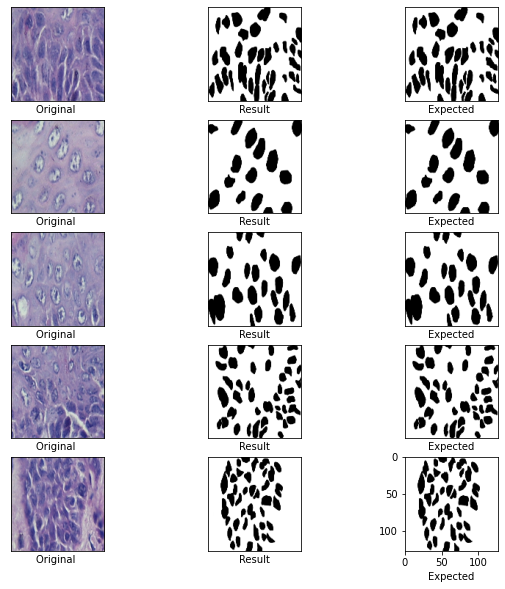

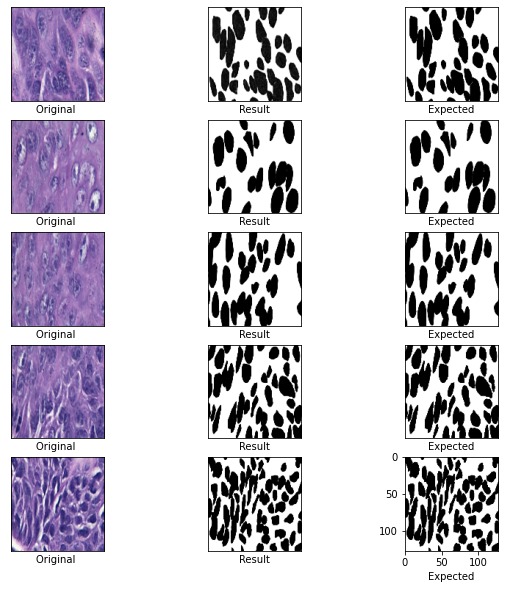

In [29]:
path_mild_img = '../dataset/segmentation/mild/'
path_mild_val = '../dataset/segmentation/annotation/mild/'

mild_img = load_all_imgs(path_mild_img, img_size, 1)
mild_val = load_all_imgs(path_mild_val, img_size, 0)
mild_pred = model.predict(mild_img)
# ----- Primeiras 5 Imagens -----
plot_result(mild_pred[:5], mild_img[:5], mild_val[:5])
# ----- Ultimas 5 Imagens -----
plot_result(mild_pred[-5:], mild_img[-5:], mild_val[-5:])

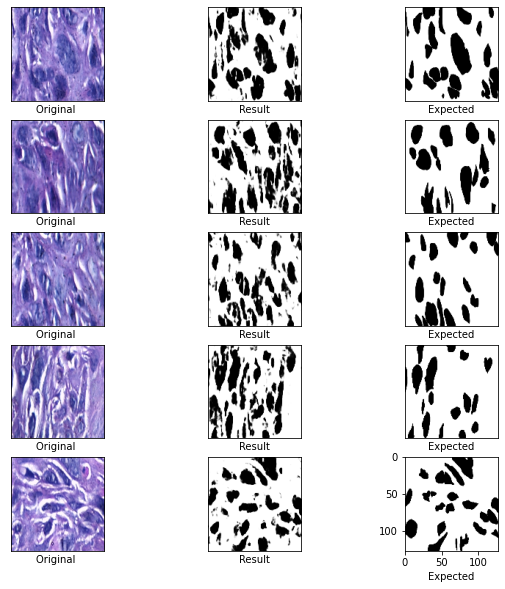

In [33]:
pred_imgs = trainImgs[-5:]
pred_valid = validImgs[-5:]
severe_pred = model.predict(pred_imgs)

plot_result(severe_pred, pred_imgs, pred_valid)

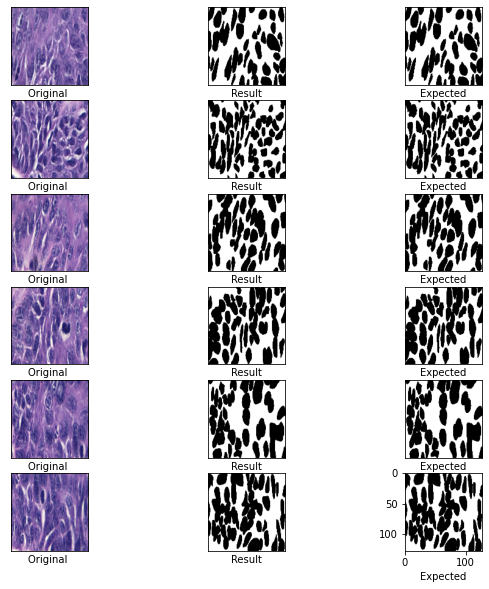

In [34]:
pred_imgs = trainImgs[61:67]
pred_valid = validImgs[61:67]
val_preds = model.predict(pred_imgs)
plot_result(val_preds, pred_imgs, pred_valid)